In [138]:
import pandas as pd
import numpy as np

## Loading Datasets

In [139]:
labels = ['Lagged', 'MA', 'WMA', 'MA-Lagged', 'WMA-Lagged']

def load_datasets():
    datasets = dict()
    for lb in labels:
        new_df = pd.read_excel(f"River-Data-{lb}.xlsx")
        new_df.drop(["Unnamed: 0"], axis=1, inplace=True)
        datasets[lb] = new_df
    
    return datasets

data = load_datasets()

## Building Feature Sets

In [140]:
def build_feature_set(*datasets):
    assert len(datasets) > 0, "No data sets entered"
    datasets = list(datasets)
    min_rows = min(d.shape[0] for d in datasets)
    
    for i, ds in enumerate(datasets):
        datasets[i] = ds.truncate(before=ds.shape[0]-min_rows).reset_index()
        datasets[i].drop(["index"], axis=1, inplace=True)
        
    merged_df = datasets[0].iloc[:, :2]
    for ds in datasets:
        merged_df = pd.concat([merged_df, ds.iloc[:, 2:]], axis=1)
    
    merged_cols = list(merged_df.columns)
    selected_cols = []
    
    for i in range(0, len(merged_cols), 2):
        format_str = f"{i+1}) {merged_cols[i]}"
        if i != len(merged_cols) - 1:
            second_part = f"{i+2}) {merged_cols[i+1]}"
            num_spaces = 50 - len(format_str)
            format_str += num_spaces*" " + second_part
        print(format_str)
    
    selected_indices = input("\nSelect columns: ")
    for index in selected_indices.split(","):
        if "-" in index:
            first_i, second_i = index.split("-")
            selected_cols += merged_cols[int(first_i) - 1: int(second_i)]
        else:
            selected_cols.append(merged_cols[int(index) - 1])
    
    return merged_df[selected_cols]

## Correlations Between Features

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

# Utility function for plotting a correlation heatmap
def plot_correlation_matrix(corr_data, title, figsize=(16,6), mask=False):
    if mask:
        mask = np.triu(np.ones_like(corr_data, dtype=bool))
    plt.figure(figsize=figsize, dpi=500)
    heatmap = sns.heatmap(corr_data, vmin=-1, vmax=1, annot=True, mask=mask)
    heatmap.set_title(title)
    plt.show()

In [150]:
# fs = build_feature_set(data['WMA-Lagged'], data['WMA'], data['Lagged'], data['MA'], data['MA-Lagged'])
fs = build_feature_set(data['Lagged'])

1) Date                                           2) Skelton MDF (Cumecs)
3) Crakehill MDF (t-1)                            4) Skip Bridge MDF (t-1)
5) Westwick MDF (t-1)                             6) Skelton MDF (t-1)
7) Crakehill MDF (t-2)                            8) Skip Bridge MDF (t-2)
9) Westwick MDF (t-2)                             10) Skelton MDF (t-2)
11) Crakehill MDF (t-3)                           12) Skip Bridge MDF (t-3)
13) Westwick MDF (t-3)                            14) Skelton MDF (t-3)
15) Arkengarthdale DRT (t-1)                      16) East Cowton DRT (t-1)
17) Malham Tarn DRT (t-1)                         18) Snaizeholme DRT (t-1)
19) Arkengarthdale DRT (t-2)                      20) East Cowton DRT (t-2)
21) Malham Tarn DRT (t-2)                         22) Snaizeholme DRT (t-2)
23) Arkengarthdale DRT (t-3)                      24) East Cowton DRT (t-3)
25) Malham Tarn DRT (t-3)                         26) Snaizeholme DRT (t-3)

Select columns: 1,2,3-6,23-2

In [151]:
fs

,Date,Skelton MDF (Cumecs),Crakehill MDF (t-1),Skip Bridge MDF (t-1),Westwick MDF (t-1),Skelton MDF (t-1),Arkengarthdale DRT (t-3),East Cowton DRT (t-3),Malham Tarn DRT (t-3),Snaizeholme DRT (t-3)
0,1993-01-04,23.47,9.46,4.124,8.057,23.60,0.0,0.0,0.0,4.0
1,1993-01-05,60.70,9.41,4.363,7.925,23.47,0.0,0.0,0.8,0.0
2,1993-01-06,98.01,26.30,11.962,58.704,60.70,0.0,0.0,0.8,0.0
3,1993-01-07,56.99,32.10,10.237,34.416,98.01,2.4,24.8,0.8,61.6
4,1993-01-08,56.66,19.30,7.254,22.263,56.99,11.2,5.6,33.6,111.2
...,...,...,...,...,...,...,...,...,...,...
1443,1996-12-27,29.52,11.70,6.075,12.671,33.06,0.0,0.0,0.0,0.0
1444,1996-12-28,28.67,10.90,5.721,11.558,29.52,0.0,3.2,0.8,1.6
1445,1996-12-29,29.31,11.10,5.486,11.411,28.67,0.0,0.8,0.0,0.0
1446,1996-12-30,34.28,12.10,5.329,11.781,29.31,1.6,14.4,8.8,3.2


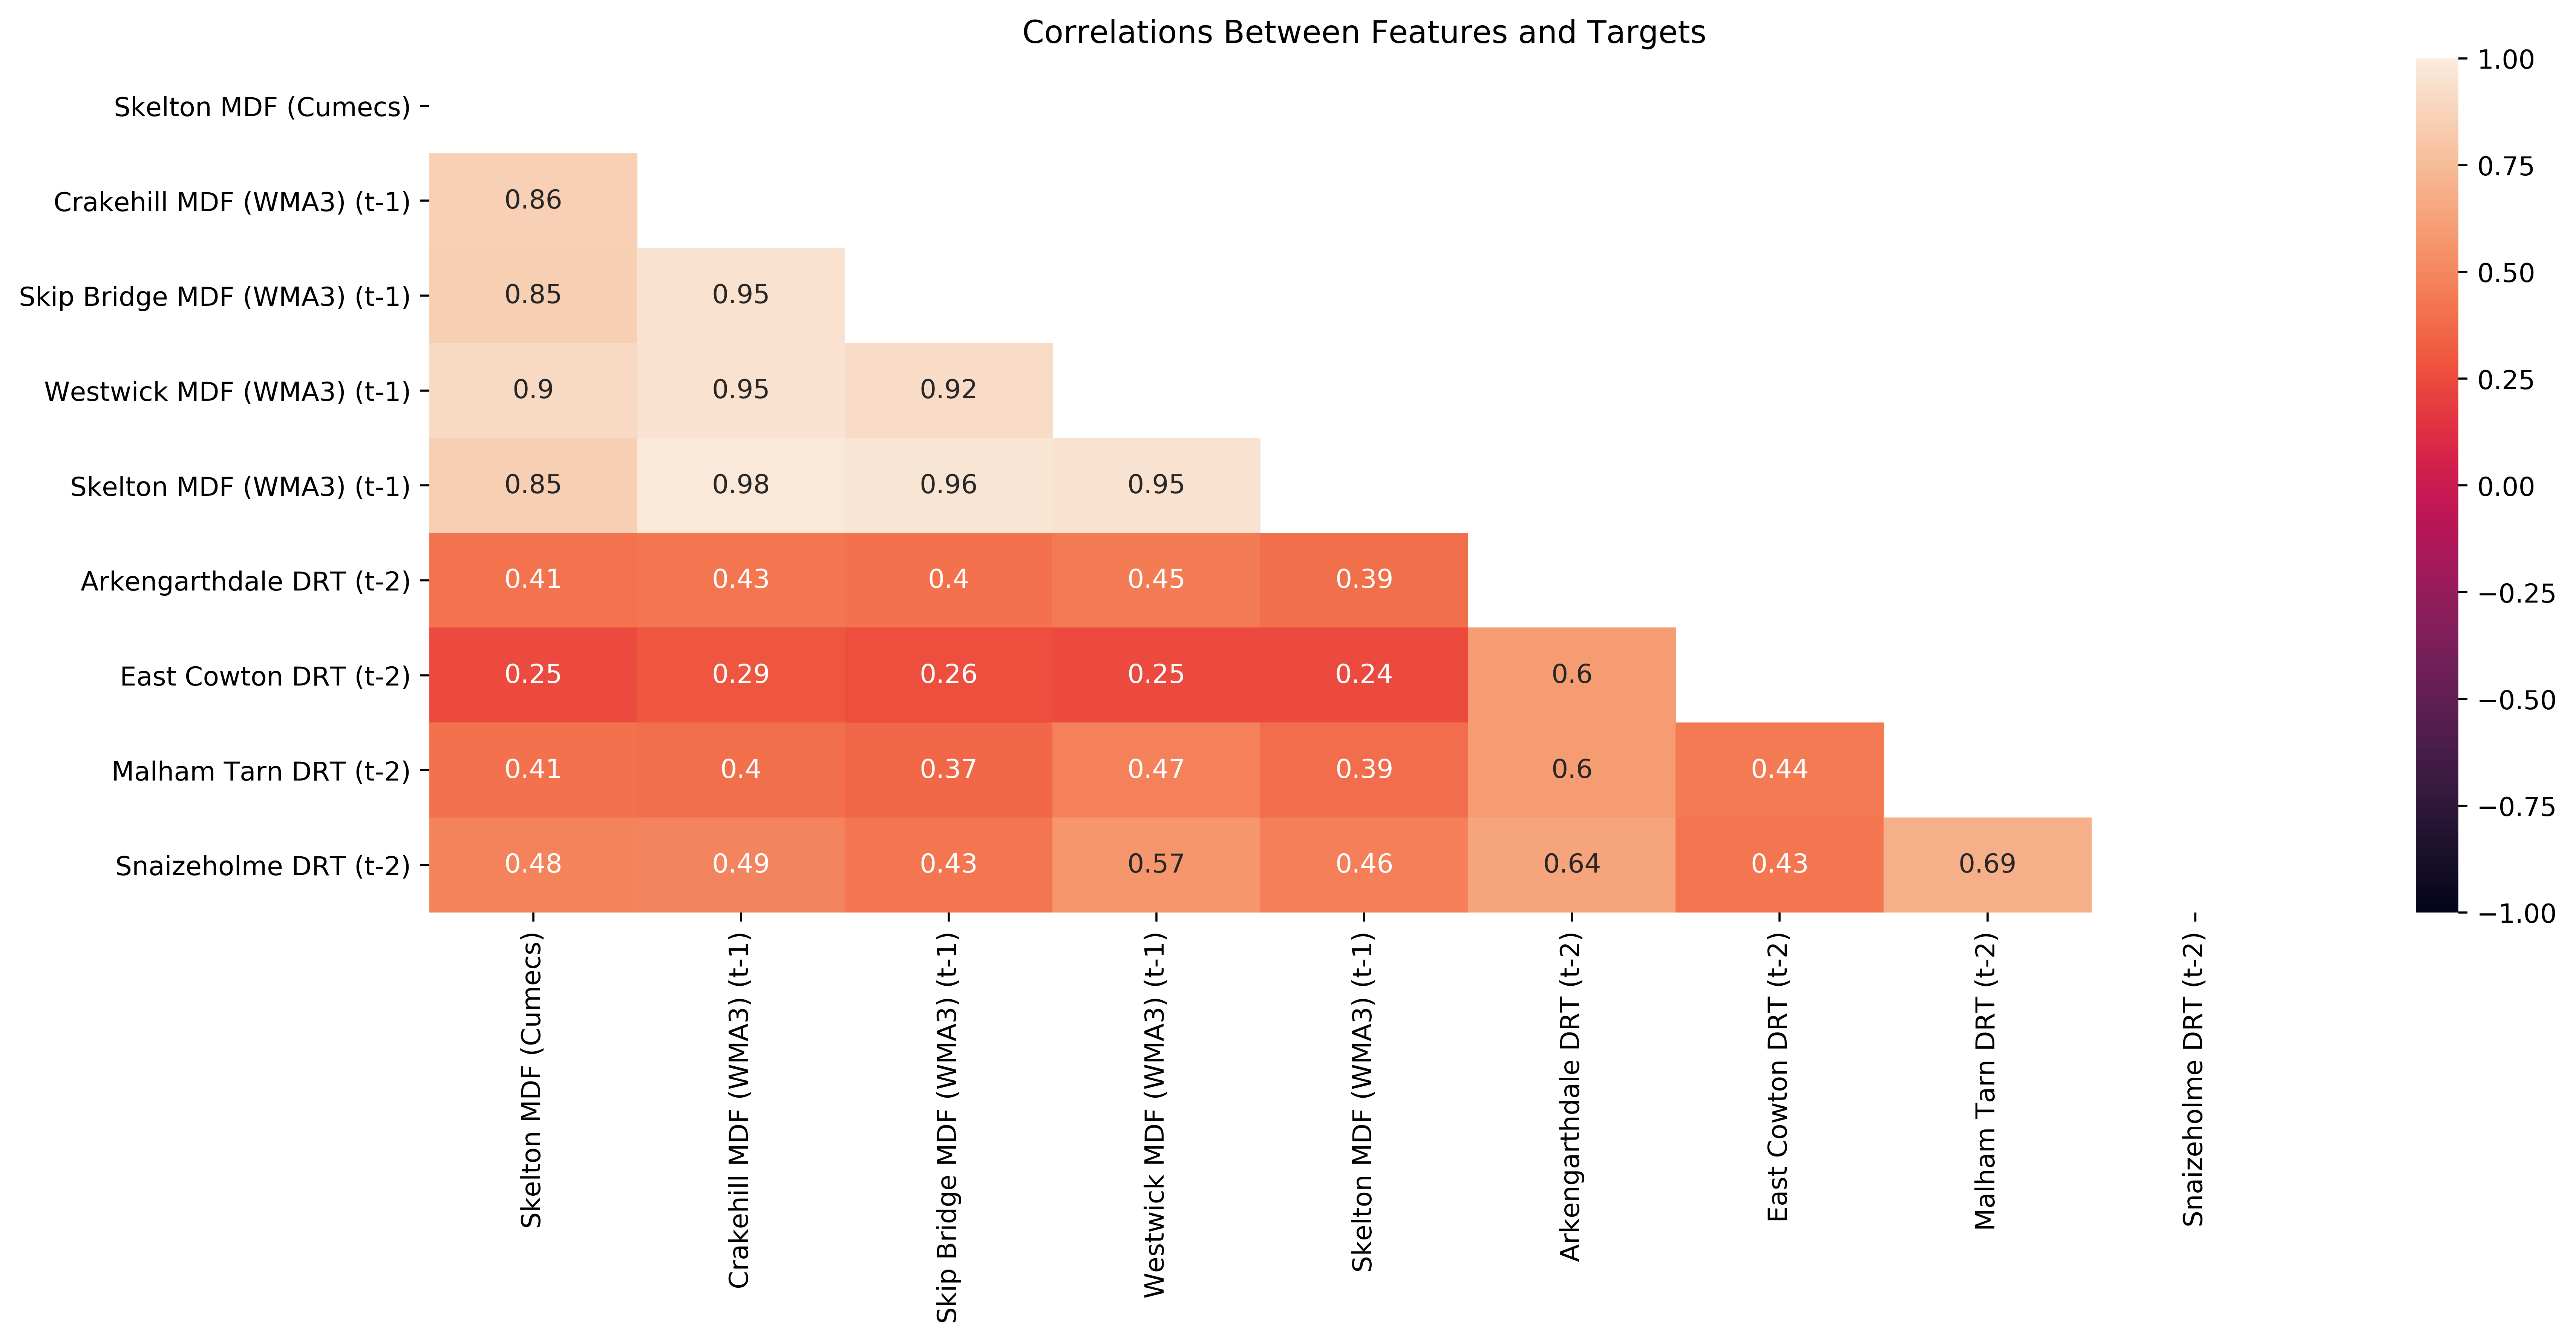

In [149]:
plot_correlation_matrix(fs.corr(), "Correlations Between Features and Targets", mask=True)